In [1]:
import numpy as np
import plotly.graph_objects as go
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from typing import List, Union
import scipy.optimize as spo
from collections import Counter

In [2]:
class Fiber_pair:
    def __init__(self, core_r = 0,   clad_r = 0,   core_n = 0,   clad_n = 0,
                       core_r_2 = 0, clad_r_2 = 0, core_n_2 = 0, clad_n_2 = 0, 
                       z_max = 0, diffusion = None):
        self.diffusion = diffusion
        self.core_r = core_r
        self.clad_r = clad_r
        self.core_n = core_n
        self.clad_n = clad_n
        self.core_r_2 = core_r_2
        self.clad_r_2 = clad_r_2
        self.core_n_2 = core_n_2
        self.clad_n_2 = clad_n_2
        self.z_max = z_max
    def set_geometry(self, core_r, clad_r, core_r_2, clad_r_2, z): #радиусы принимаются в метрах
        self.core_r = core_r
        self.clad_r = clad_r
        self.core_r_2 = core_r_2
        self.clad_r_2 = clad_r_2
        self.z_max = z
    def set_refr(self, core_n, clad_n, core_n_2, clad_n_2):
        self.core_n = core_n
        self.clad_n = clad_n
        self.core_n_2 = core_n_2
        self.clad_n_2 = clad_n_2
    def radius(self):
        return self.core_r, self.clad_r, self.core_r_2, self.clad_r_2
    def refr(self):
        return self.core_n, self.clad_n, self.core_n_2, self.clad_n_2 
    def find_normal(self, intersection_point):
        x, y = intersection_point[:2]
        result = -1 * np.array([x, y, 0])/np.sqrt(x**2 + y**2)
        return result # Возвращает нормаль к поверхности, направленную к центру цилиндра

In [3]:
class Fiber_cylinder:
    def __init__(self, core_r = 0, clad_r = 0, core_n = 0, clad_n = 0, z_max = 0, diffusion = None):
        self.diffusion = diffusion
        self.core_r = core_r
        self.clad_r = clad_r
        self.core_n = core_n
        self.clad_n = clad_n
        self.z_max = z_max
    def set_geometry(self, core_r, clad_r, z): #радиусы принимаются в метрах
        self.core_r = core_r
        self.clad_r = clad_r
        self.z_max = z
    def set_refr(self, core_n, clad_n):
        self.core_n = core_n
        self.clad_n = clad_n
    def radius(self):
        return self.core_r, self.clad_r
    def refr(self):
        return self.core_n, self.clad_n
    def find_normal(self, intersection_point):
        x, y = intersection_point[:2]
        result = -1 * np.array([x, y, 0])/np.sqrt(x**2 + y**2)
        return result # Возвращает нормаль к поверхности, направленную к центру цилиндра
    

In [4]:
class Ray_pair:
    def __init__(self, azimut = 0, latitude = 0, startpoint = [0,0,0]): #все углы принимаются в радианах
        self.cdf = None
        self.angles = None
        self.index = True
        self.azimut = azimut
        self.latitude = latitude
        self.startpoint = startpoint
        self.vector = [np.sin(latitude)*np.cos(azimut),
                      np.sin(latitude)*np.sin(azimut), 
                      np.cos(latitude)]
    
    def set_values(self, azimut, latitude, startpoint):
        self.azimut = azimut
        self.latitude = latitude
        self.startpoint = startpoint
        self.vector = [np.sin(latitude)*np.cos(azimut),
                      np.sin(latitude)*np.sin(azimut), 
                      np.cos(latitude)]
    def calculate_angles_from_vector(self, vector):
        latitude = np.arccos(vector[2])
        if latitude == 0:
            return [0, 0]
        cos = vector[0] / np.linalg.norm(vector[:2])
        sin = vector[1] / np.linalg.norm(vector[:2])
        if sin > 0:
            azimut = np.arccos(cos)
        else:
            azimut = -np.arccos(cos)
        return [azimut, latitude]
    
    def calculate_intersection(self, core_radius):
        if self.latitude == 0:
            return [*self.startpoint[:2], -1]
        x0, y0, z0 = self.startpoint
        phi, alpha = self.azimut, self.latitude
        R = core_radius
        gamma = np.cos(phi)*x0 + np.sin(phi)*y0
        if gamma**2 - x0**2 - y0**2 + R**2 >= 0:
            x = x0 + np.cos(phi) * (-gamma + np.sqrt(gamma**2 - x0**2 - y0**2 + R**2))
            y = y0 + np.sin(phi) * (-gamma + np.sqrt(gamma**2 - x0**2 - y0**2 + R**2))
            z = z0 + np.cos(alpha) / np.sin(alpha) * (-gamma + np.sqrt(gamma**2 - x0**2 - y0**2 + R**2))

            return [x, y, z]
        else:
            return None
    def find_chord_length(self, core_radius):
        if self.latitude == 0:
            return np.inf
        x0, y0, z0 = self.startpoint
        phi, alpha = self.azimut, self.latitude
        R = core_radius
        gamma = np.cos(phi)*x0 + np.sin(phi)*y0
        if gamma**2 - x0**2 - y0**2 + R**2 > 0:
            x1 = x0 + np.cos(phi) * (-gamma + np.sqrt(gamma**2 - x0**2 - y0**2 + R**2))
            y1 = y0 + np.sin(phi) * (-gamma + np.sqrt(gamma**2 - x0**2 - y0**2 + R**2))
            z1 = z0 + np.cos(alpha) / np.sin(alpha) * (-gamma + np.sqrt(gamma**2 - x0**2 - y0**2 + R**2))
            x2 = x0 + np.cos(phi) * (-gamma - np.sqrt(gamma**2 - x0**2 - y0**2 + R**2))
            y2 = y0 + np.sin(phi) * (-gamma - np.sqrt(gamma**2 - x0**2 - y0**2 + R**2))
            z2 = z0 + np.cos(alpha) / np.sin(alpha) * (-gamma + np.sqrt(gamma**2 - x0**2 - y0**2 + R**2))
            return np.sqrt((x1-x2)**2 + (y1-y2)**2 + (z1-z2)**2)
        else:
            return None
        
    def consumption(self, ppm, length):
        N = ppm * 6.62e22
        sigma = 1.4e-24
        probability = 1-np.exp(-N*sigma*length)
        rand = np.random.random()
        if rand < probability:
            return True
        else:
            return False
        
    def calculate_reflection(self, point, normal):
        cosine  = np.dot(normal, self.vector)
        proection = normal * cosine
        angle = np.arccos(abs(cosine))
        reflected_vector = -2 * proection + self.vector
        return *self.calculate_angles_from_vector(reflected_vector), angle
    
    def generate_startpoint(self, radius):
        phi = np.random.random() * np.pi
        r = np.random.random() * radius
        coords = [r*np.cos(phi), r*np.sin(phi)]
        self.startpoint = [*coords, 0]
        return [*coords, 0]
    
    def set_startpoint(self, x = 0, y = 0, z = 0):
        self.startpoint = [x, y, z]
        return self.startpoint
    
    def generate_angles(self, max_latitude = 30):
        latitude = np.deg2rad(np.random.random() * max_latitude)
        azimut = np.deg2rad(np.random.random() * 360)
        self.azimut = azimut
        self.latitude = latitude
        self.vector = [np.sin(latitude)*np.cos(azimut),
                      np.sin(latitude)*np.sin(azimut), 
                      np.cos(latitude)]
        return [latitude, azimut]
    def generate_angles_uniform(self, max_latitude = 10, step = 0.1):
        if self.cdf is None:                                                         # Если кумулятивная функция распределения не посчитана
            n = max_latitude / step                                           # Количество точек разбиения
            self.angles = np.linspace(0, np.deg2rad(max_latitude), int(n))    # Массив углов с осью 
            solid_angles = np.array([2*np.pi*(1-np.cos(x)) for x in self.angles])  # Массив телесных углов
            solid_angles_diff = np.diff(solid_angles)                         # Массив производных телесных углов
            pdf = solid_angles_diff / sum(solid_angles_diff)                  # Функция плотности вероятности
            self.cdf = np.array([np.sum(pdf[:i]) for i in range(len(pdf)+1)]) # Кумулятивная функция плотности распределения
        self.azimut = np.deg2rad(np.random.random() * 360)
        rand = np.random.random()
        index = 0
        for i, c in enumerate(self.cdf):
            if c > rand:
                index = i
                break
        self.latitude = self.angles[index] # Обратная cdf # Обратная cdf
        self.vector = [np.sin(self.latitude)*np.cos(self.azimut),
                      np.sin(self.latitude)*np.sin(self.azimut), 
                      np.cos(self.latitude)]
        self.index = True
        return [self.azimut, self.latitude]
    
    def set_angles(self, azimut, latitude):
        self.azimut = azimut
        self.latitude = latitude
        self.vector = [np.sin(latitude)*np.cos(azimut),
                      np.sin(latitude)*np.sin(azimut), 
                      np.cos(latitude)]
        return [latitude, azimut]
    
    def calculate_trajectory(self, fiber1, fiber2, fiber_core, max_reflection = 1000, angle_elimination = True, output = False):
        z_max = fiber1.z_max
        self.index = True
        termination_angle = np.arcsin(fiber1.clad_n / fiber1.core_n)
        Dots = np.zeros((max_reflection, 3))
        reflection_angle = self.latitude
        Angles = np.zeros((max_reflection, 3))
        indexes = np.zeros(max_reflection)
        z_start = self.startpoint[2]
        indexes[0] = self.index
        Dots[0] = self.startpoint
        Angles[0] = [self.azimut, self.latitude, 0]
        for i in range(1, max_reflection):
            if self.index:
                intersection_point = self.calculate_intersection(fiber1.core_r)
            else:
                intersection_point = self.calculate_intersection(fiber2.core_r)
                intersection_core = self.calculate_intersection(fiber_core.core_r)
                if intersection_core:
                    length = self.find_chord_length(fiber_core.core_r)
                    if self.consumption(400, length):
                        Dots[i] = intersection_core
                        Angles[i] = [self.azimut, self.latitude, 0]
                        indexes[i] = self.index
                        if output:
                            print('Ray consumed by core')
                        return Dots, np.rad2deg(Angles), i + 1, 'consumption', indexes
            if intersection_point[0] > fiber1.core_r * 0.8 and self.index == True:
                indexes[i] = self.index
                self.index = False
                Dots[i] = intersection_point
                Dots[i][0] *= 0.8
                Angles[i] = [self.azimut, self.latitude, 0]
                i += 1
                if i == max_reflection:
                    continue
                indexes[i] = self.index
                Dots[i] = intersection_point
                Dots[i][0] *= -0.8 / fiber1.core_r * fiber2.core_r
                Dots[i][1] *= fiber2.core_r / fiber1.core_r
                Angles[i] = [self.azimut, self.latitude, 0]
                self.set_values(self.azimut, self.latitude, Dots[i])
                continue
            elif intersection_point[0] < fiber2.core_r * -0.8 and self.index == False:
                indexes[i] = self.index
                self.index = True
                Dots[i] = intersection_point
                Dots[i][0] *= 0.8
                Angles[i] = [self.azimut, self.latitude, 0]
                i += 1
                if i == max_reflection:
                    continue
                indexes[i] = self.index
                Dots[i] = intersection_point
                Dots[i][0] *= -0.8 * fiber1.core_r / fiber2.core_r
                Dots[i][1] *= fiber1.core_r / fiber2.core_r
                Angles[i] = [self.azimut, self.latitude, 0]
                self.set_values(self.azimut, self.latitude, Dots[i])
                continue
            if intersection_point[2] > z_max:
                intersection_final = intersection_point - self.vector / self.vector[2] * (intersection_point[2] - z_max) 
                Dots[i] = intersection_final
                Angles[i] = [self.azimut, self.latitude, abs(reflection_angle)]
                indexes[i] = self.index
                if output:
                    print('Ray reached z_max.')
                return Dots, np.rad2deg(Angles), i + 1, 'z_max', indexes
            if self.index:
                normal = fiber1.find_normal(intersection_point)
            else:
                normal = fiber2.find_normal(intersection_point)
            azimut, latitude, reflection_angle = self.calculate_reflection(intersection_point, normal)
            if fiber1.diffusion:
                azimut += (np.random.random() - 0.5 ) * 2 * fiber1.diffusion
                latitude += (np.random.random() - 0.5 ) * 2 * fiber1.diffusion
            Dots[i] = intersection_point
            Angles[i] = [azimut, latitude, abs(reflection_angle)]
            indexes[i] = self.index
            if angle_elimination:
                if reflection_angle < termination_angle:
                    if output:
                        print('Ray terminated, termination angle: ', np.rad2deg(termination_angle),' reflection_angle: ',  np.rad2deg(np.pi / 2 - abs(reflection_angle)))
                    return Dots, np.rad2deg(Angles), i + 1, 'reflection_angle', indexes
            self.set_values(azimut, latitude, intersection_point)
        if output:
            print('Reflections exceeded', max_reflection)
        return Dots, np.rad2deg(Angles), max_reflection, 'max_reflections', indexes

In [5]:
def calculate_multiple_trajectories_pair(fiber1, fiber2, fiber_core, trajectory_count = 100, max_reflection = 1000, output = False, angle = 8, startpoints = None, startangles = None):
    trajectories = np.zeros((trajectory_count, max_reflection, 3))
    angles = np.zeros((trajectory_count, max_reflection, 3))
    indexes = np.zeros((trajectory_count, max_reflection))
    reflections = np.zeros(trajectory_count)
    termination = ["" for x in range(trajectory_count)] # 0 - max_z, 1 - max_reflection, 2 - reflection angle
    ray_internal = Ray_pair()
    for i in tqdm(range(trajectory_count), leave = False):
        
        if startpoints:
            ray_internal.set_startpoint(*startpoints[i])
        else:
            ray_internal.generate_startpoint(fiber1.core_r)
         
        if startangles:
            ray_internal.set_angles(*startangles[i])
        else:    
            ray_internal.generate_angles_uniform(max_latitude = angle)
            
            
        trajectories[i], angles[i], reflections[i], termination[i], indexes[i] = ray_internal.calculate_trajectory(fiber1, fiber2, fiber_core, max_reflection=max_reflection, output = output)
    dictionary = {
        'angles':       angles.tolist(),
        'trajectories': trajectories.tolist(),
        'reflections':  reflections.tolist(),
        'termination':  termination,
        'indexes':      indexes.tolist()
    }
    return pd.DataFrame(dictionary)

In [6]:
crit = np.rad2deg(np.pi / 2 - np.arcsin(1.387 / 1.445))
print(crit)

16.288502934527187


In [7]:
z_final = 0.3
fiber_1 = Fiber_cylinder(core_r=330e-6/2, clad_r=660e-6, core_n=1.445, clad_n=1.387, z_max=z_final)
fiber_2 = Fiber_cylinder(core_r=62.5e-6, clad_r=660e-6, core_n=1.445, clad_n=1.387, z_max=z_final)
fiber_core = Fiber_cylinder(core_r=27.5e-6, clad_r=660e-6, core_n=1.445, clad_n=1.387, z_max=z_final)
data = calculate_multiple_trajectories_pair(fiber_1, fiber_2, fiber_core, trajectory_count = int(1e3), max_reflection=10000, output=False, angle = 17)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [8]:
#data_filtered = data[data.termination=='consumption'].reset_index()
z_max = z_final
data_filtered = data
x = np.linspace(0, z_max, 100, endpoint=True)
ray_count = np.zeros(len(x)-1)
ray_count_2 = np.zeros(len(x)-1)
for i in tqdm(range(data_filtered.shape[0])):
    z_array = [data_filtered.trajectories[i][k][2] for k in range(int(data_filtered.reflections[i]))]
    for j, coordinate in enumerate(x[:-1]):
        ind = int(next((z[0] for z in enumerate(z_array) if z[1] > coordinate), -1))
        if ind != -1:
            if data_filtered.indexes[i][ind] == True:
                ray_count[j] += 1
            else:
                ray_count_2[j] += 1

  0%|          | 0/1000 [00:00<?, ?it/s]

In [9]:
print(ray_count)
print(ray_count_2)

[1000.  729.  725.  724.  732.  698.  706.  704.  668.  708.  679.  676.
  689.  672.  647.  680.  662.  675.  665.  654.  668.  677.  668.  671.
  680.  652.  651.  664.  648.  685.  668.  642.  657.  661.  661.  657.
  644.  654.  656.  664.  637.  630.  646.  621.  649.  641.  651.  664.
  665.  652.  620.  654.  635.  622.  630.  649.  630.  610.  644.  633.
  618.  635.  611.  638.  644.  647.  634.  631.  612.  645.  609.  637.
  624.  617.  640.  590.  614.  641.  609.  622.  622.  623.  647.  609.
  636.  616.  621.  631.  633.  623.  614.  601.  606.  614.  608.  619.
  630.  609.  606.]
[  0. 230. 227. 224. 212. 241. 232. 232. 264. 223. 251. 249. 236. 253.
 278. 244. 262. 248. 257. 267. 253. 244. 251. 246. 232. 260. 260. 245.
 260. 222. 238. 262. 247. 241. 237. 238. 249. 239. 237. 228. 252. 258.
 242. 267. 236. 243. 233. 219. 215. 227. 259. 221. 240. 252. 242. 222.
 241. 260. 226. 236. 251. 234. 257. 229. 222. 219. 231. 232. 251. 218.
 254. 226. 237. 243. 220. 268. 244. 215. 

In [10]:
def Extract_finish_data(data):
    data_zm = data[(data['termination'] == 'z_max')].reset_index()
    print(len(data_zm))
    finish_points = np.array([data_zm['trajectories'][i][int(data_zm['reflections'][i]) - 1] for i in range(len(data_zm))])
    mask = np.array([data_zm['indexes'][i][int(data_zm['reflections'][i]) - 1] for i in range(len(data_zm))])
    for dot in finish_points:
        dot[2] = 0
    finish_points_1 = finish_points[mask.astype(bool)]
    finish_points_2 = finish_points[~mask.astype(bool)]
    
    finish_angles = np.array([data_zm['angles'][i][int(data_zm['reflections'][i]) - 1][:2] for i in range(len(data_zm))])
    finish_angles_1 = finish_angles[mask.astype(bool)]
    finish_angles_2 = finish_angles[~mask.astype(bool)]
    return finish_points_1, list(np.deg2rad(finish_angles_1)), finish_points_2, list(np.deg2rad(finish_angles_2))
finishpoints_1, finishangles_1, finishpoints_2, finishangles_2 = Extract_finish_data(data_filtered)

842


In [11]:
finish_latitude_1 = np.array([angle[1] for angle in finishangles_1])
finish_latitude_2 = np.array([angle[1] for angle in finishangles_2])
finish_latitude_1_end = finish_latitude_1
finish_latitude_2_end = finish_latitude_2

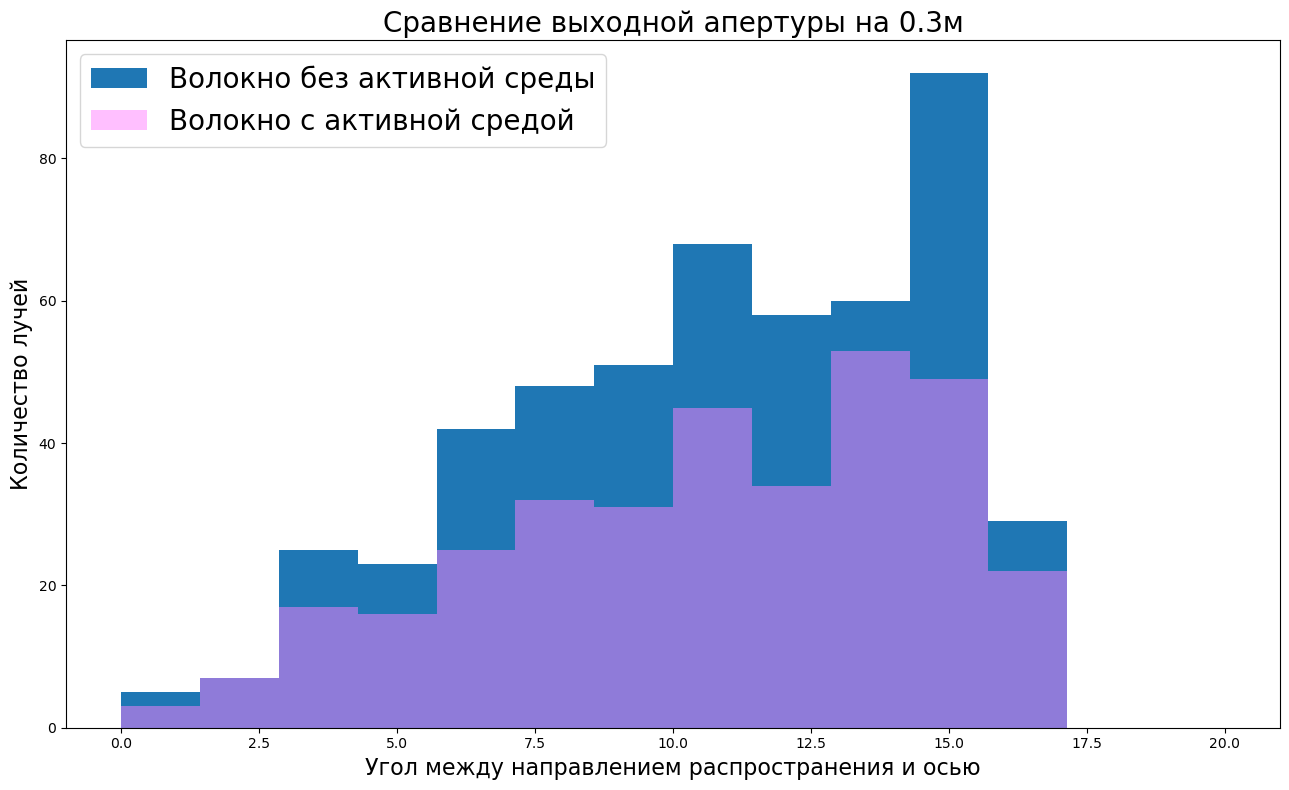

In [12]:

x = np.linspace(0, 20, 15)
plt.figure(figsize = (13,8))
plt.title(f'Сравнение выходной апертуры на {z_final}м', fontsize=20)
plt.hist(np.rad2deg(finish_latitude_1_end), bins=np.array(x), label = 'Волокно без активной среды')
plt.hist(np.rad2deg(finish_latitude_2_end), bins=np.array(x), fc=(1, 0.5, 1, 0.5), label = 'Волокно с активной средой')
plt.ylabel('Количество лучей', fontsize=16)
plt.legend(fontsize=20)
plt.xlabel('Угол между направлением распространения и осью', fontsize=16)
plt.tight_layout()
plt.savefig('app comparison.png', dpi=300)
plt.show()

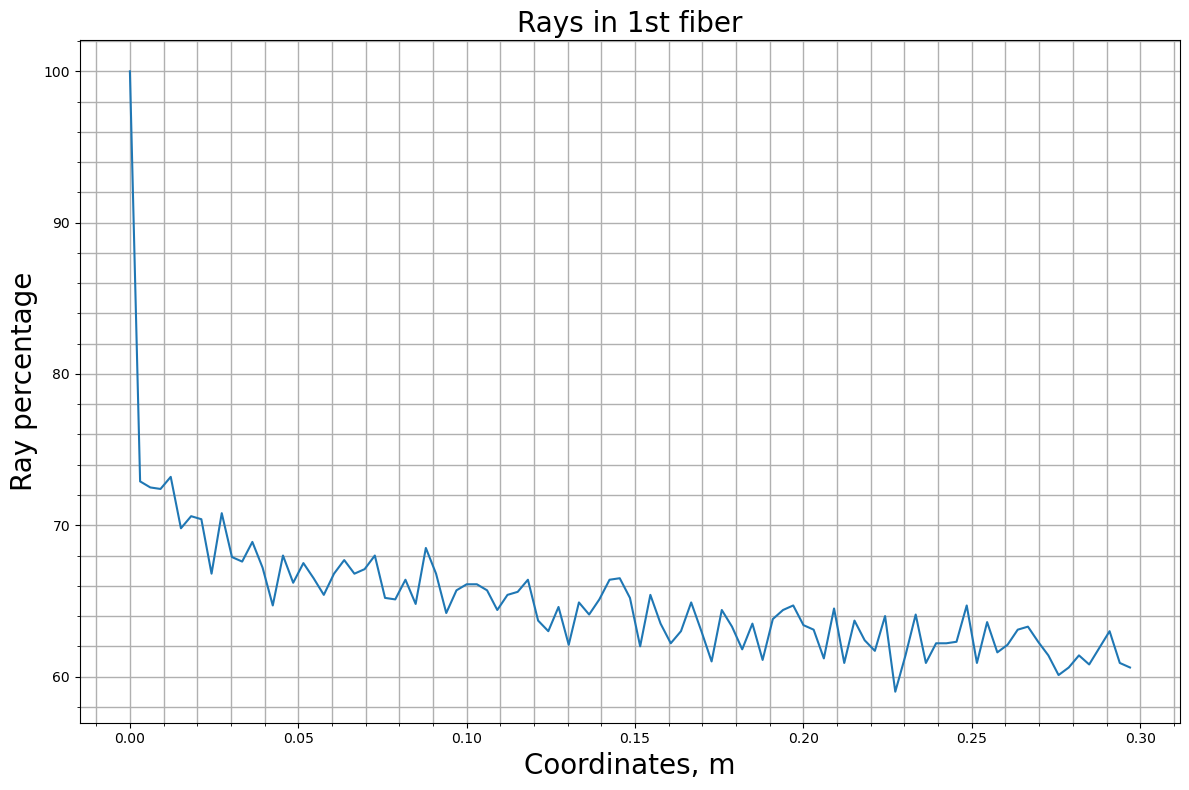

In [13]:
x = np.linspace(0, z_max, 100, endpoint=True)
plt.figure(figsize = (12, 8))
plt.plot(x[:-1], np.array(ray_count) / data_filtered.shape[0] * 100)
plt.title('Rays in 1st fiber', fontsize=20)
plt.xlabel('Coordinates, m', fontsize = 20)
plt.ylabel('Ray percentage', fontsize = 20)
plt.minorticks_on()
plt.grid(which="both", linestyle='-', linewidth=1)
plt.tight_layout()
plt.show()

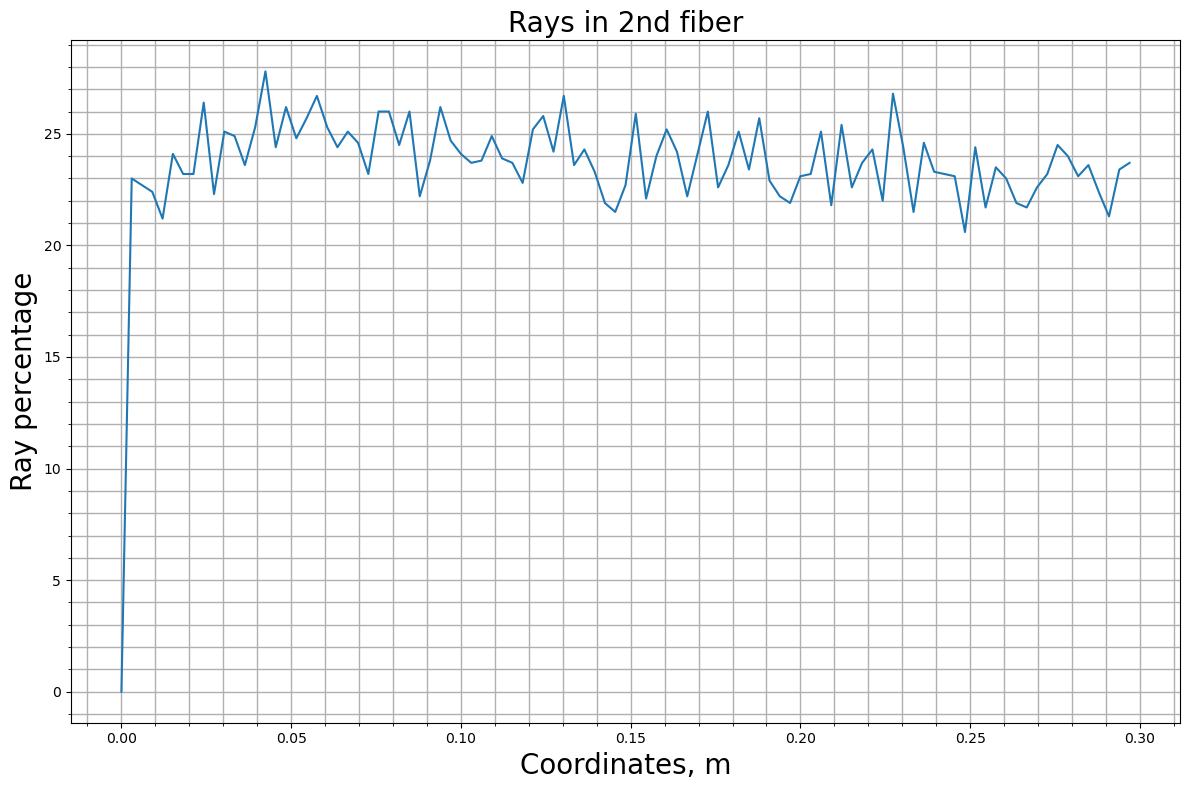

In [14]:
plt.figure(figsize = (12, 8))
plt.plot(x[:-1], np.array(ray_count_2) / data_filtered.shape[0] * 100)
plt.title('Rays in 2nd fiber', fontsize=20)
plt.xlabel('Coordinates, m', fontsize = 20)
plt.ylabel('Ray percentage', fontsize = 20)
plt.minorticks_on()
plt.grid(which="both", linestyle='-', linewidth=1)
plt.tight_layout()
plt.show()

In [15]:
data_filtered = data[data.termination=='consumption'].reset_index()
x = np.linspace(0, z_max, 100, endpoint=True)
ray_count_consumption = np.zeros(len(x))
z_cons = [data_filtered.trajectories[i][int(data_filtered.reflections[i]-1)][2] for i in range(len(data_filtered.trajectories))]
ray_count_consumption = [sum(coord < lim for coord in z_cons) for lim in x]

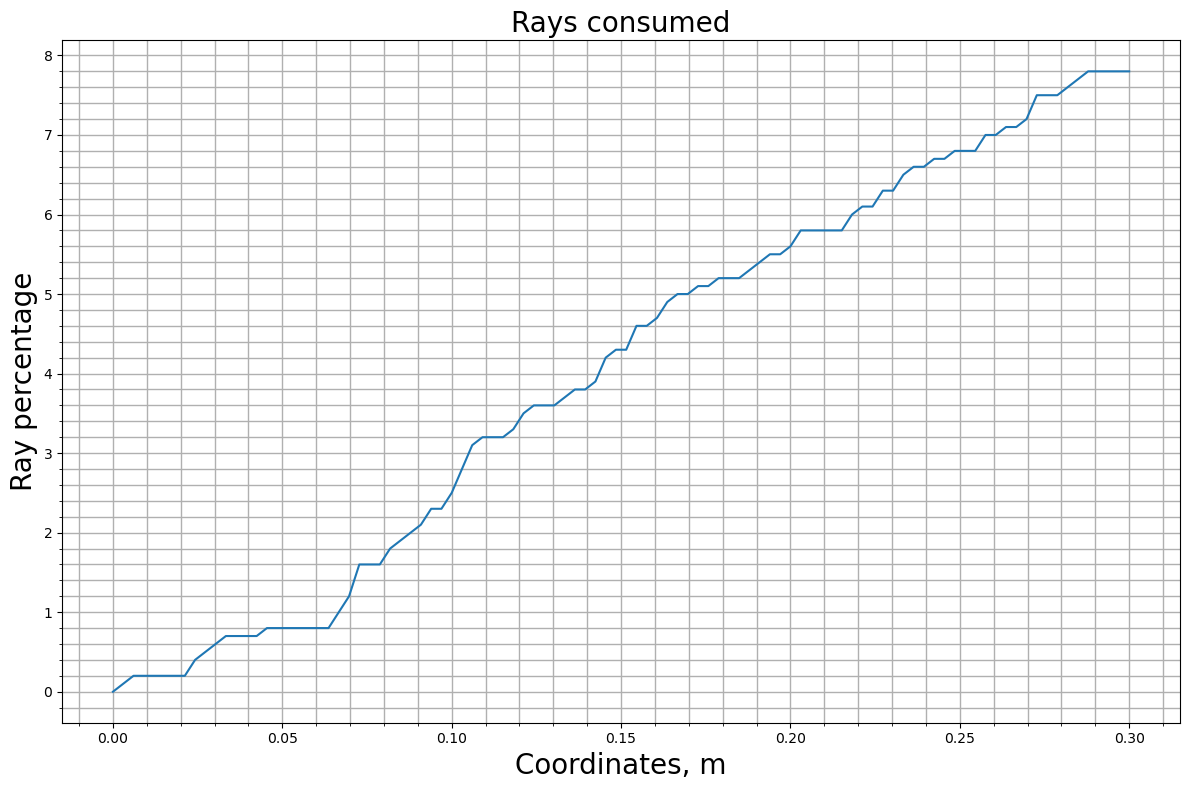

In [16]:
plt.figure(figsize = (12, 8))
plt.plot(x, np.array(ray_count_consumption) / data.shape[0] * 100)
plt.title('Rays consumed', fontsize=20)
plt.xlabel('Coordinates, m', fontsize = 20)
plt.ylabel('Ray percentage', fontsize = 20)
plt.minorticks_on()
plt.grid(which="both", linestyle='-', linewidth=1)
plt.tight_layout()
plt.show()

In [17]:
def generate_angles_uniform(max_latitude = 10, step = 0.1):
    n = max_latitude / step                                           # Количество точек разбиения
    angles = np.linspace(0, np.deg2rad(max_latitude), int(n))    # Массив углов с осью 
    solid_angles = np.array([2*np.pi*(1-np.cos(x)) for x in angles])  # Массив телесных углов
    solid_angles_diff = np.diff(solid_angles)                         # Массив производных телесных углов
    solid_angles_diff = np.array([2*np.pi*np.sin(x) for x in angles])[:-1]
    pdf = solid_angles_diff / sum(solid_angles_diff)                 # Функция плотности вероятности
    cdf = np.array([np.sum(pdf[:i]) for i in range(len(pdf)+1)]) # Кумулятивная функция плотности распределения
    azimut = np.deg2rad(np.random.random() * 360)
    rand = np.random.random()
    index = 0
    for i, c in enumerate(cdf):
        if c > rand:
            index = i
            break
        
    latitude = angles[index] # Обратная cdf
    return [azimut, latitude], cdf, np.rad2deg(angles)


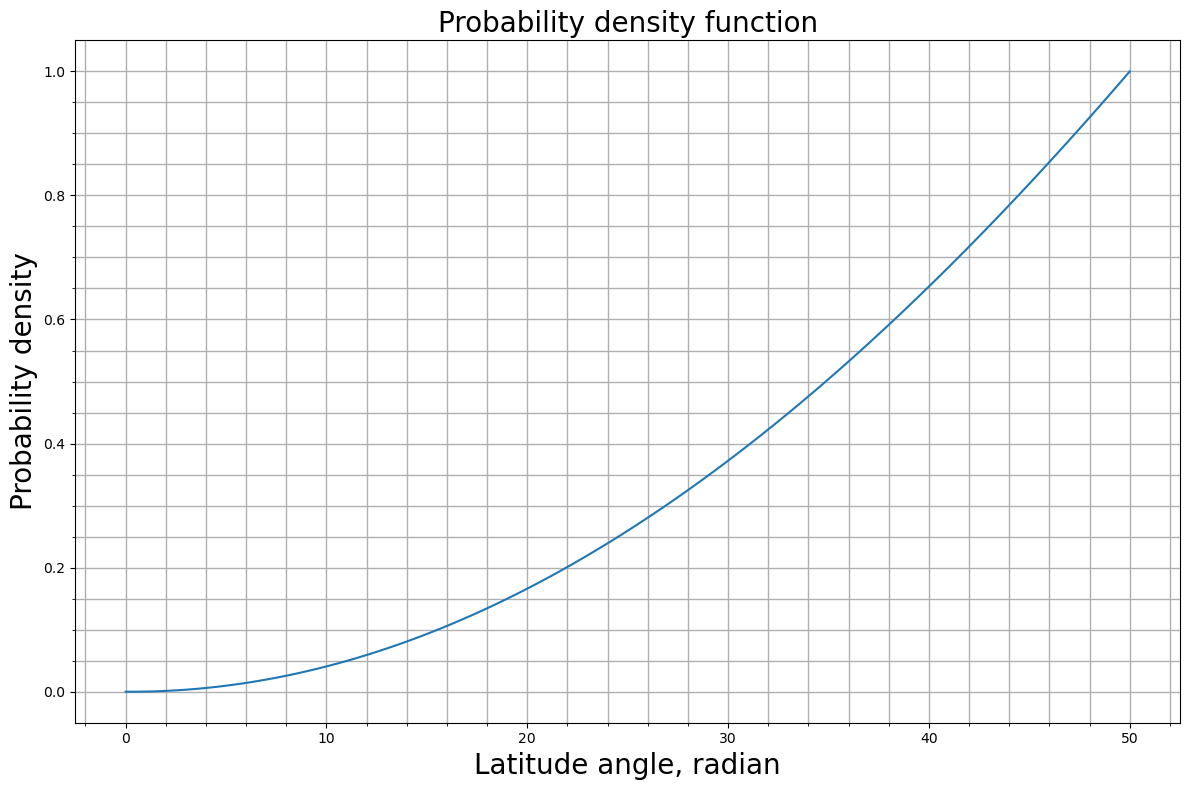

In [18]:
_, cdf, angles = generate_angles_uniform(max_latitude = 50, step = 0.5)
x = [0.5 * i for i in range(100)]
plt.figure(figsize = (12, 8))
plt.plot(angles, cdf)
plt.title('Probability density function', fontsize=20)
plt.xlabel('Latitude angle, radian', fontsize = 20)
plt.ylabel('Probability density', fontsize = 20)
plt.minorticks_on()
plt.grid(which="both", linestyle='-', linewidth=1)
plt.tight_layout()
plt.show()

In [19]:
plt.figure(figsize = (12, 8))
plt.plot(pdf, cdf)
plt.title('Cumulative distribution function', fontsize=20)
plt.xlabel('Latitude angle, radian', fontsize = 20)
plt.ylabel('Cumulative distribution', fontsize = 20)
plt.minorticks_on()
plt.grid(which="both", linestyle='-', linewidth=1)
plt.tight_layout()
plt.show()

NameError: name 'pdf' is not defined

<Figure size 1200x800 with 0 Axes>

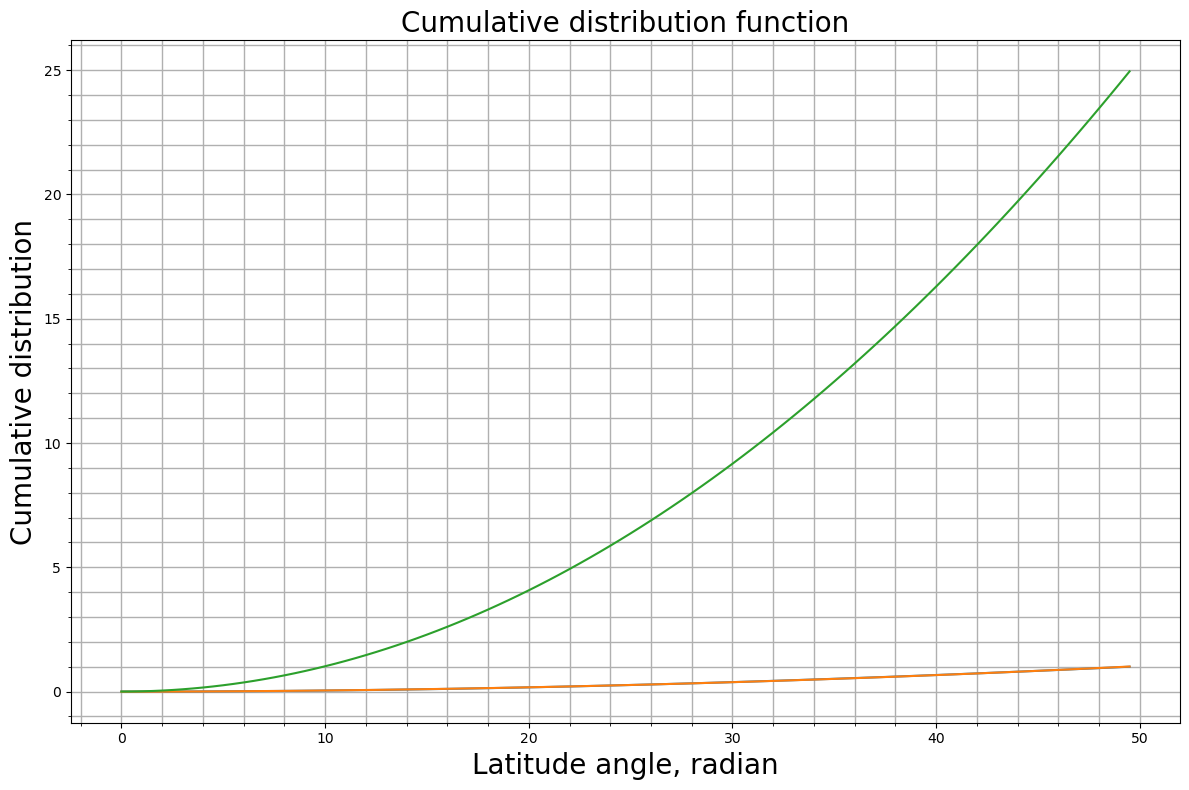

In [20]:
fit = np.polyfit(x, cdf, 2)
p = np.poly1d(fit)
plt.figure(figsize = (12, 8))
plt.plot(x, cdf)
plt.plot(x, p(x))
plt.plot(x, 0.0101844 * np.array(x)**2)
plt.title('Cumulative distribution function', fontsize=20)
plt.xlabel('Latitude angle, radian', fontsize = 20)
plt.ylabel('Cumulative distribution', fontsize = 20)
plt.minorticks_on()
plt.grid(which="both", linestyle='-', linewidth=1)
plt.tight_layout()
plt.show()

In [29]:
n = 1000
rays = np.zeros((n, 2))
latitudes = np.zeros(n)
for i in range(len(rays)):
    rays[i], _, _ = generate_angles_uniform(max_latitude = 17)
    latitudes[i] = rays[i][1]
vector = np.zeros((n,3))

for i, ray in enumerate(rays):
    azimut = ray[0]
    latitude = ray[1]
    vector[i] = [np.sin(latitude)*np.cos(azimut),
                np.sin(latitude)*np.sin(azimut), 
                np.cos(latitude)]
def farzone(vectors, z_max = 1):
    coordinates = np.zeros((vectors.shape[0], 2))
    for i, vector in enumerate(vectors):
        x = vector[0]
        y = vector[1]
        z = vector[2]
        coef = z_max / z
        #print(coef)
        coordinates[i][0] = x * coef
        coordinates[i][1] = y * coef
        if x * coef > 100:
            print(coef, x, y, z, i)
    plt.figure(figsize = (8, 8))
    plt.scatter(coordinates.T[0], coordinates.T[1], alpha=0.5)
    plt.title('Дальняя зона', fontsize=20)
    plt.xlabel('x, m', fontsize = 20)
    plt.ylabel('y, m', fontsize = 20)
    plt.minorticks_on()
    plt.grid(which="both", linestyle='-', linewidth=1)
    plt.tight_layout()
    plt.show()
    return coordinates

In [22]:
print(np.rad2deg(max(rays.T[1])))

20.0


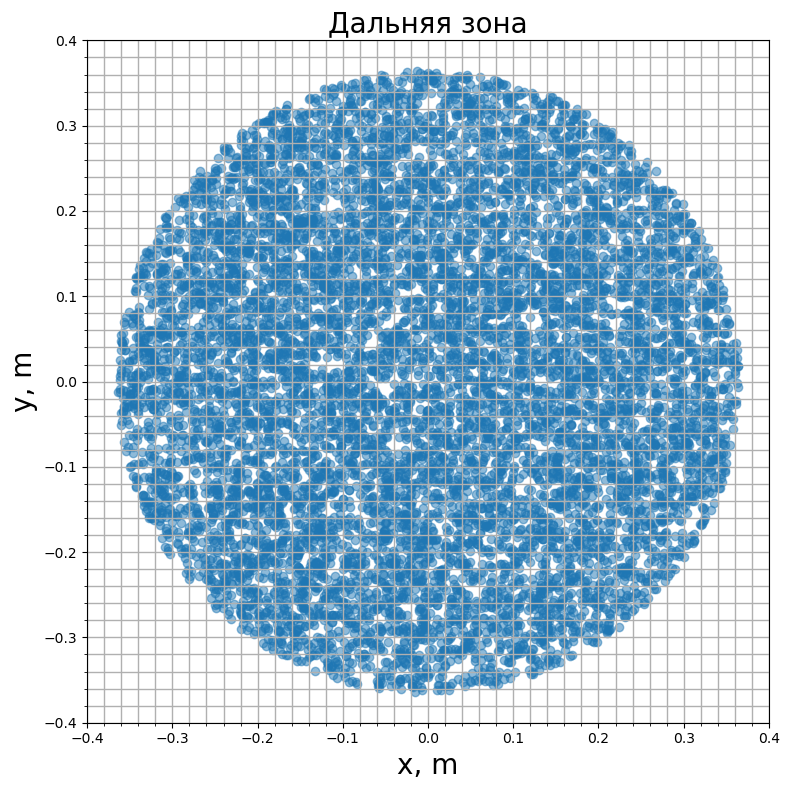

In [23]:
coordinates_1 = farzone(vector)

In [24]:
def generate_angles(max_latitude = 10):
    latitude = np.deg2rad(np.random.random() * max_latitude)
    azimut = np.deg2rad(np.random.random() * 360)
    return [azimut, latitude]
n = 10000
rays = np.zeros((n, 2))
for i in range(len(rays)):
    rays[i] = generate_angles()
vector_2 = np.zeros((n,3))

for i, ray in enumerate(rays):
    azimut = ray[0]
    latitude = ray[1]
    vector_2[i] = [np.sin(latitude)*np.cos(azimut),
                np.sin(latitude)*np.sin(azimut), 
                np.cos(latitude)]

In [ ]:
coordinates_2 =  farzone(vector_2)

In [ ]:
print(vector_2[i])

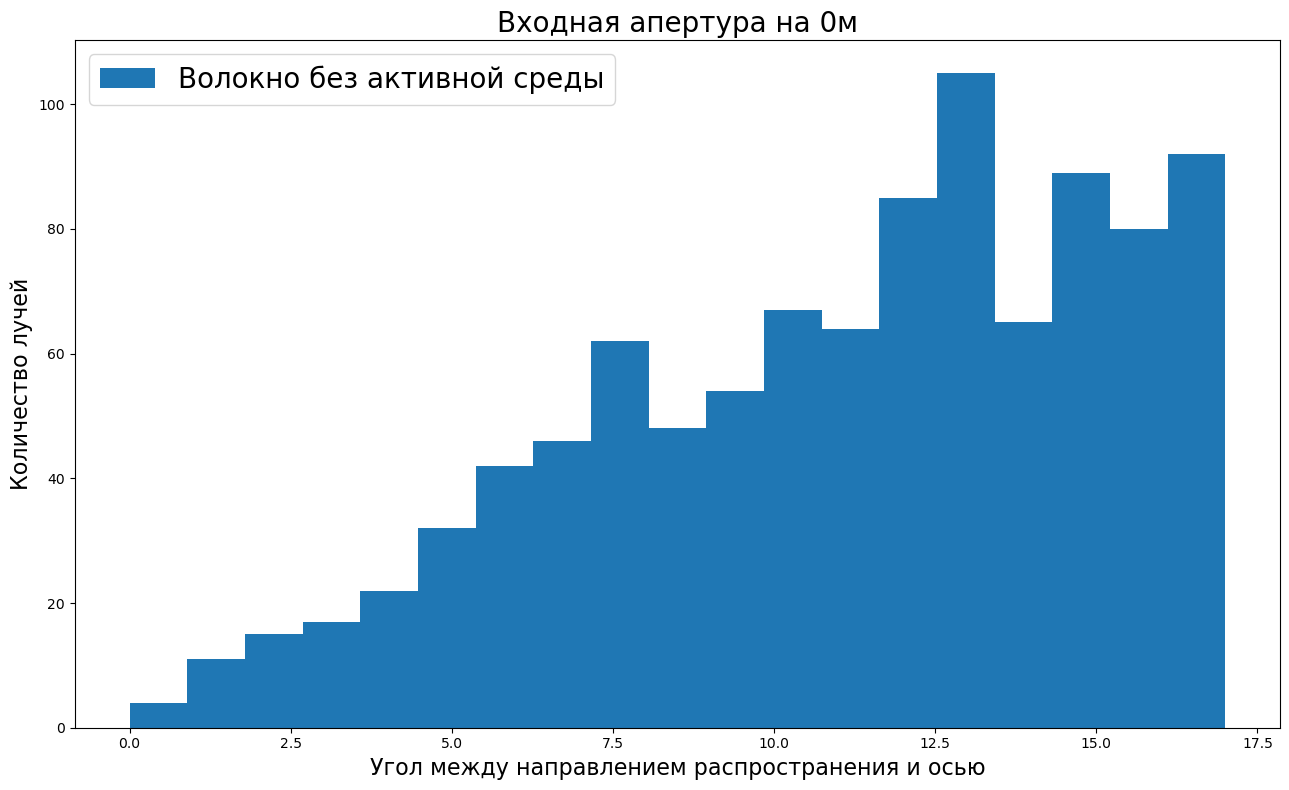

In [30]:
x = np.linspace(0, 17, 20)
plt.figure(figsize = (13,8))
plt.title('Входная апертура на 0м', fontsize=20)
plt.hist(np.rad2deg(latitudes), bins=np.array(x), label = 'Волокно без активной среды')
#plt.hist(0, bins=np.array(x), fc=(1, 0.5, 1, 0.5), label = 'Волокно с активной средой')
plt.ylabel('Количество лучей', fontsize=16)
plt.legend(fontsize=20)
plt.xlabel('Угол между направлением распространения и осью', fontsize=16)
plt.tight_layout()
plt.savefig('app comparison.png', dpi=300)
plt.show()

In [ ]:
def radial_dependence(coordinates):
    radius = np.zeros(len(coordinates))
    for i in range(len(radius)):
        radius[i] = np.sqrt(coordinates[i][0]**2 + coordinates[i][1]**2)
    print(radius)
    x = np.linspace(0, max(radius), 20)
    plt.figure(figsize = (13,8))
    plt.title('Зависимость количества лучей в дальней зоне от радиуса', fontsize=20)
    plt.hist(radius, bins=np.array(x))
    plt.ylabel('Количество лучей', fontsize=16)
    plt.legend(fontsize=20)
    plt.xlabel('Радиус, м', fontsize=16)
    plt.tight_layout()
    plt.show()

In [ ]:
radial_dependence(coordinates_1)

In [ ]:
radial_dependence(coordinates_2)